This notebook is used for the data analysis of the experiment "Optitrack and Leap swarm control"

I saved the values of the metrics computed by the mapping algorithm

In [1]:
data_folder = '..\\data_analysis\\data_analysis\\EXPERIMENT_PILOTS\\VALUES_STORED'

In [2]:
# needed to use modules/scripts from parent folder
import os,sys
print(sys.version)
sys.path.insert(1, os.path.join(sys.path[0], 'C:\\github\\HRI_mapping\\src'))

import HRI_mapping as HRI
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from settings.settings import get_settings
import sys
import json
import os
from matplotlib.backends.backend_pdf import PdfPages

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


In [3]:
# Not sure I even use that anymore
settings = get_settings()

In [4]:
datas_leap = [f for f in os.listdir(data_folder) if 'leap' in f]

In [5]:
# Get the data we saved from the experiments, especially the coefficients (correlation or correlation*SNR) for each subject and swarm maneuver

coeff = {}
for i,folder in enumerate(datas_leap):
    file_coeff_name = os.path.join(data_folder,folder,'coeff.json')     #for using corr * SNR
    # file_coeff_name = os.path.join(data_folder,folder,'covar.json')      # for using only the correlation
    with open(file_coeff_name) as file_coeff:
        coeff_data = json.load(file_coeff)
    coeff[i] = coeff_data

In [6]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='bottom')

In [7]:
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

In [8]:
# This was used for the previous figures we had.
# Cells bellow works for the new ones
# Not used anymore

#coeff_mean = {}
#coeff_std = {}
#for out in coeff[0].keys():
#    coeff_mean[out] = {}
#    coeff_std[out] = {}
#    for input_feat in coeff[0][out].keys():
#        list_feat_values = []
#        for subject in range(len(datas_leap)):
#            if np.sum(list(coeff[subject][out].values())) != 0:
#                list_feat_values.append(coeff[subject][out][input_feat]/np.sum(list(coeff[subject][out].values())))
#            else:
#                list_feat_values.append(0)
#        coeff_mean[out][input_feat] = np.mean(list_feat_values)
#        coeff_std[out][input_feat] = np.std(list_feat_values)

In [12]:
# Parameters to tune

thresh = 0.5         # Threshold : x% of the coefficients
n_selected_features = 20    # The maximum number of features we will add to reach the threshold (can be high)  
n_selected = 10       # How much input feats we want to plot

In [19]:
# This cell computes which features account together for more than x% of the coefficient 

coef_sum = {}   # Creates and initialize the dict
for out in coeff[0].keys():
    coef_sum[out] = {}
    for input_feat in coeff[0][out].keys():
        coef_sum[out][input_feat] = 0

for out in coeff[0].keys():
    for subject in range(len(datas_leap)):
        # These lines sort the features according to their coeff values (features for a specific subject and swarm motion)
        ind = np.argpartition(list(coeff[subject][out].values()), -n_selected_features)[-n_selected_features:]
        ind = ind[np.argsort(-np.array([list(coeff[subject][out].values())[i] for i in ind]))] # To sort the array in descending order
        name_ind = np.array(list(coeff[subject][out].keys()))[ind]
        
        coeff_data = [coeff[subject][out][n]/np.sum(list(coeff[subject][out].values())) for n in name_ind] # Coefficients values
        
        cumul_data = np.cumsum(coeff_data)   # Cumulative sum
        selected_indexes = np.where(cumul_data<thresh)[0]     # Apply the threshold
        #print(out, selected_indexes)
        
        if len(selected_indexes) == 0:
            selected_indexes = [-1]     # Will allow to select index 0 at next line
            
        for index in range(selected_indexes[-1]+2):    # This line is a bit strange... if selected_indexes=[0,1,2] I want to look at indexes 0,1,2 and 3 (due to how threshold is applied)
            input_feat = name_ind[index]
            coef_sum[out][input_feat] += 1      # We add one for each parameter selected
#print(coef_sum)

C:\Users\defoo\anaconda3\envs\hri\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\defoo\anaconda3\envs\hri\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


['input1', 'input2', 'input3', 'input4']


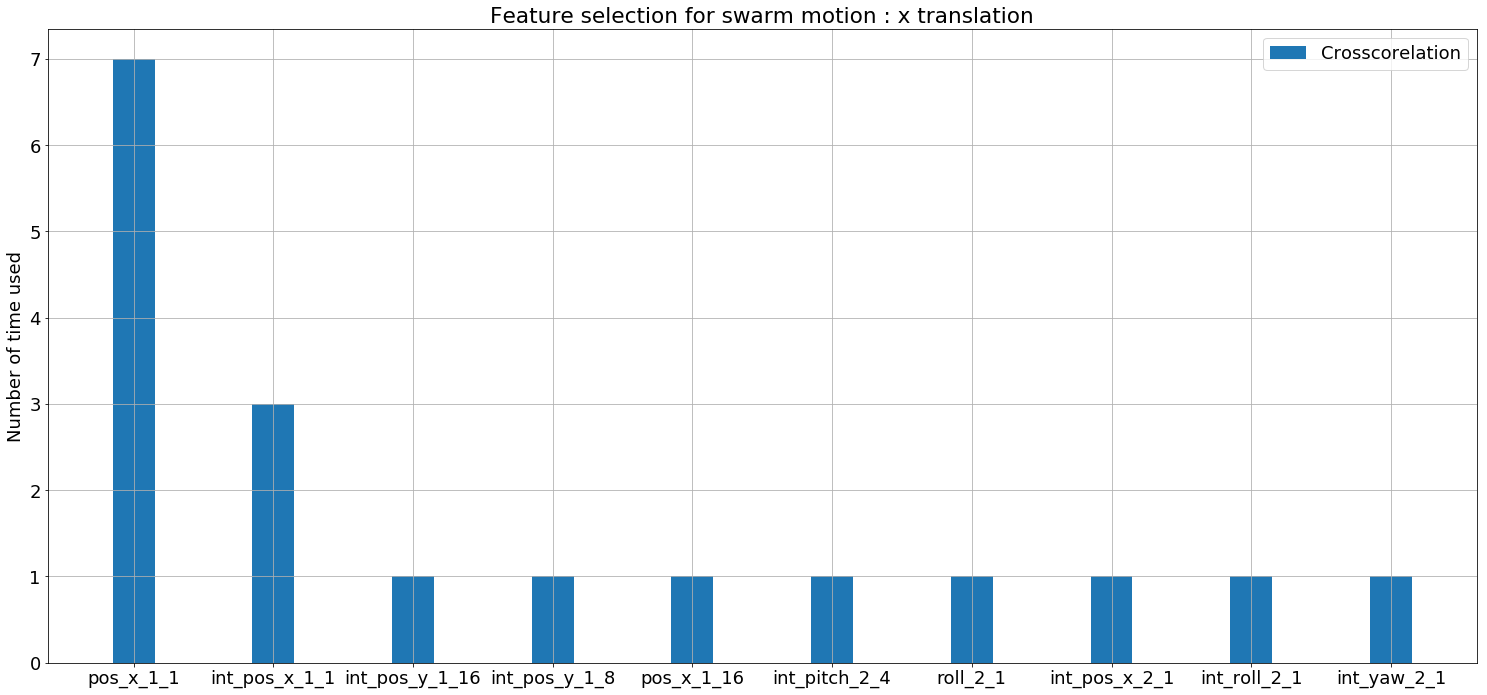

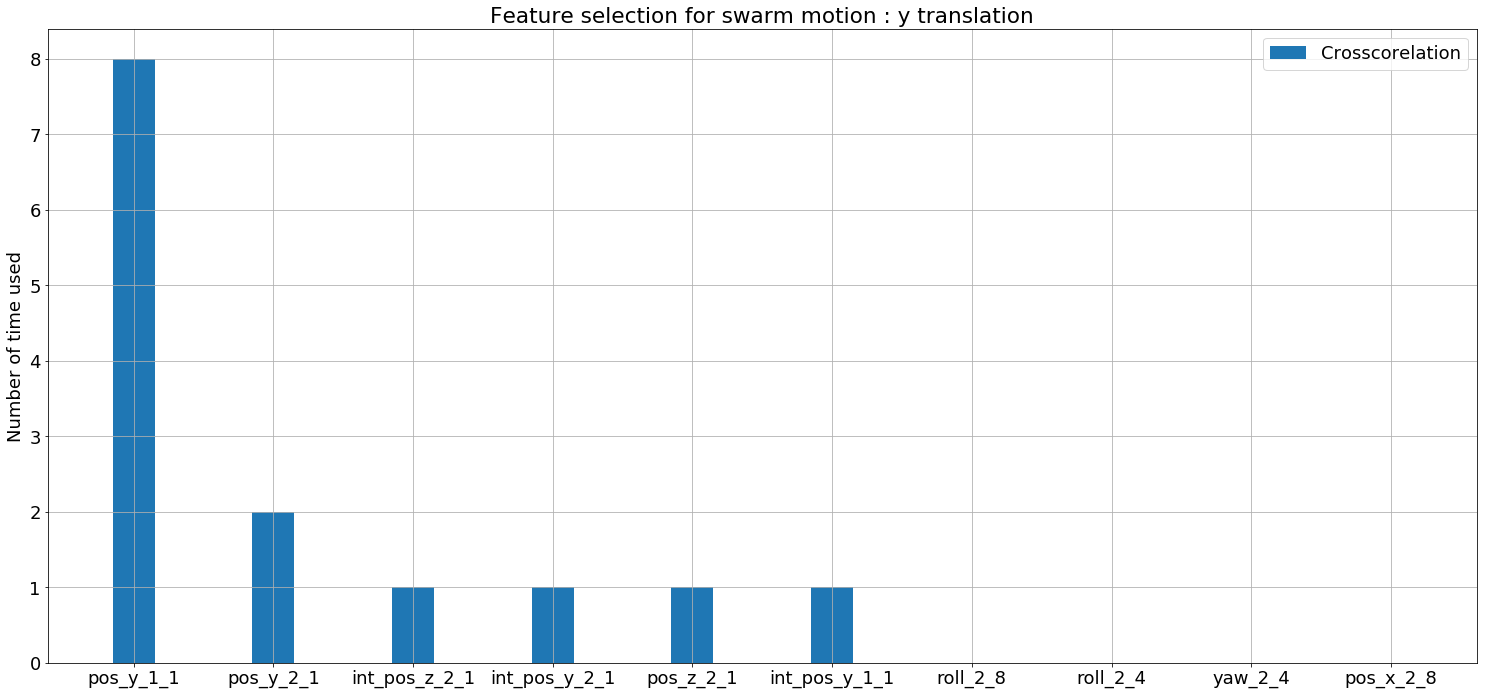

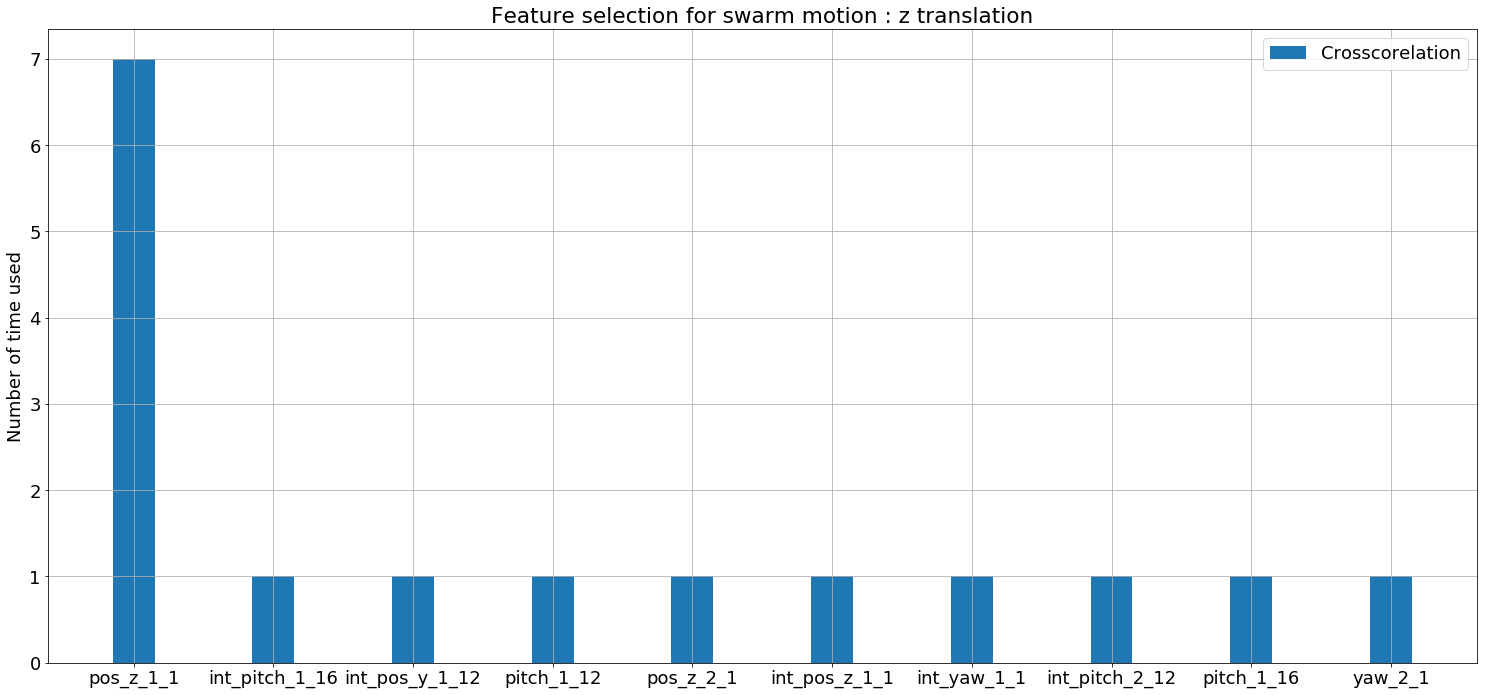

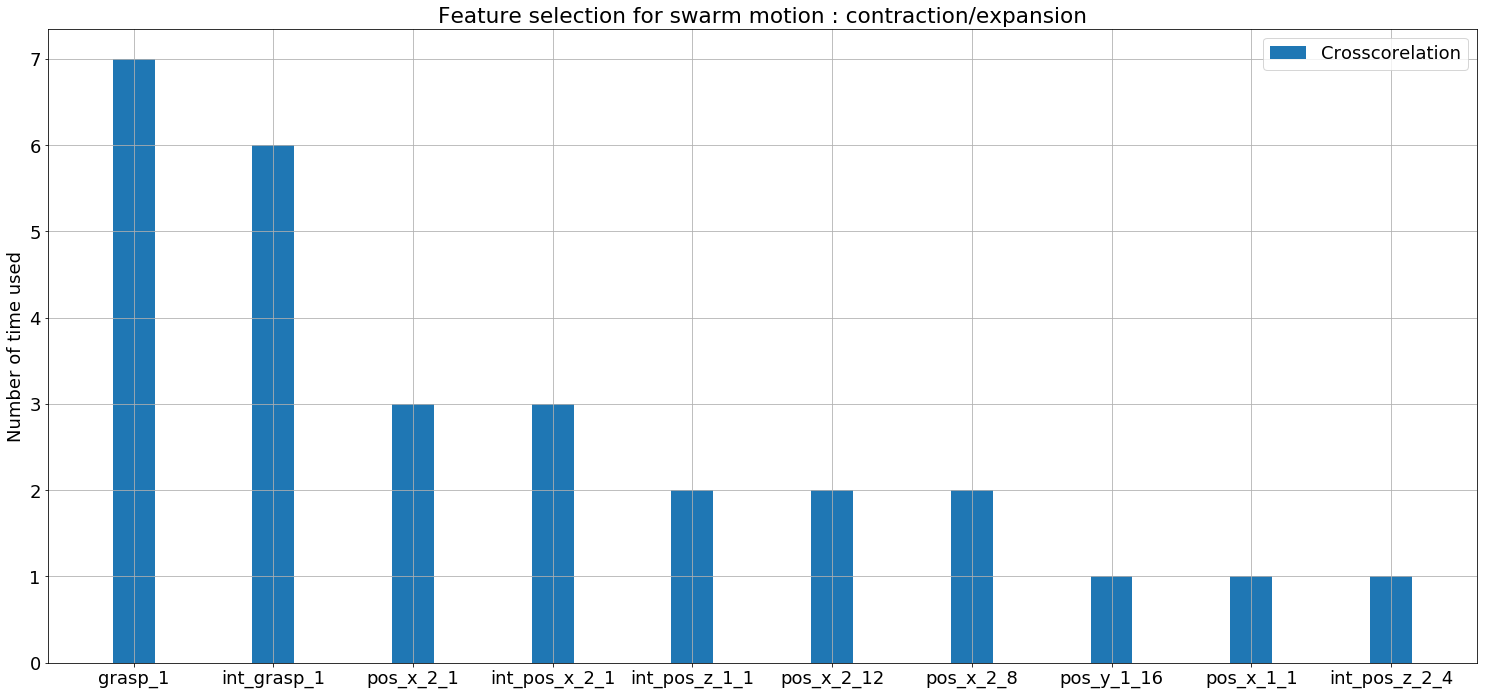

In [20]:
plt.rcParams.update({'font.size': 18})
outputs_labels = ['x translation', 'y translation', 'z translation', 'contraction/expansion']
print(list(coeff[0].keys())[:-1])
for i,out in enumerate(list(coeff[0].keys())[:-1]):
    ind = np.argpartition(list(coef_sum[out].values()), -n_selected)[-n_selected:]
    #ind = ind[np.argsort([list(coeff_mean[out].values())[i] for i in ind])] # To sort the array in ascending order
    ind = ind[np.argsort(-np.array([list(coef_sum[out].values())[i] for i in ind]))] # To sort the array in descending order
    name_ind = np.array(list(coef_sum[out].keys()))[ind]
    labels = name_ind
    coeff_data = [coef_sum[out][n] for n in name_ind]

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(2.1*n_selected,10))
    rects1 = ax.bar(x, coeff_data, width, label='Crosscorelation', capsize=10)
    #rects2 = ax.bar(x + width/2, snr_means, width, yerr=snrStd, label='SNR')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of time used')
    ax.set_title('Feature selection for swarm motion : '+outputs_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    #autolabel(rects1)
    #autolabel(rects2)

    fig.tight_layout()
    plt.grid()
    plt.show()

['input1', 'input2', 'input3', 'input4']


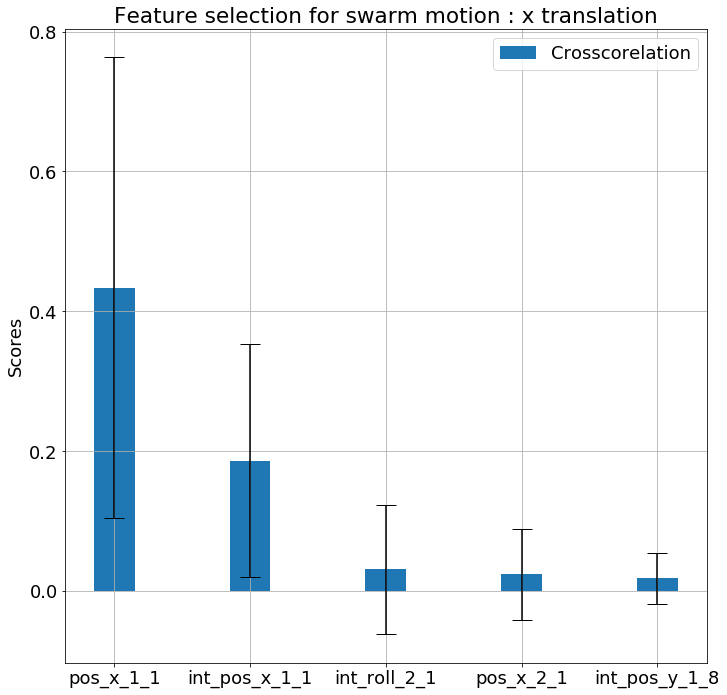

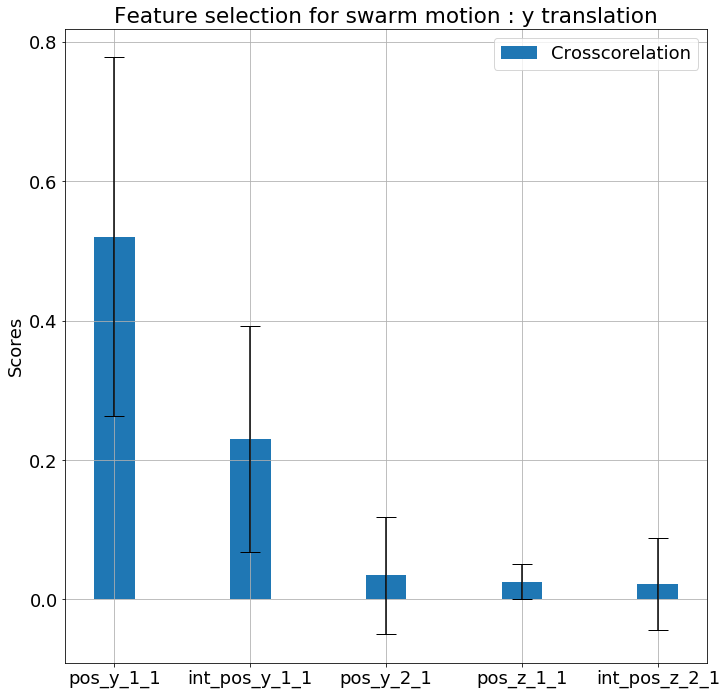

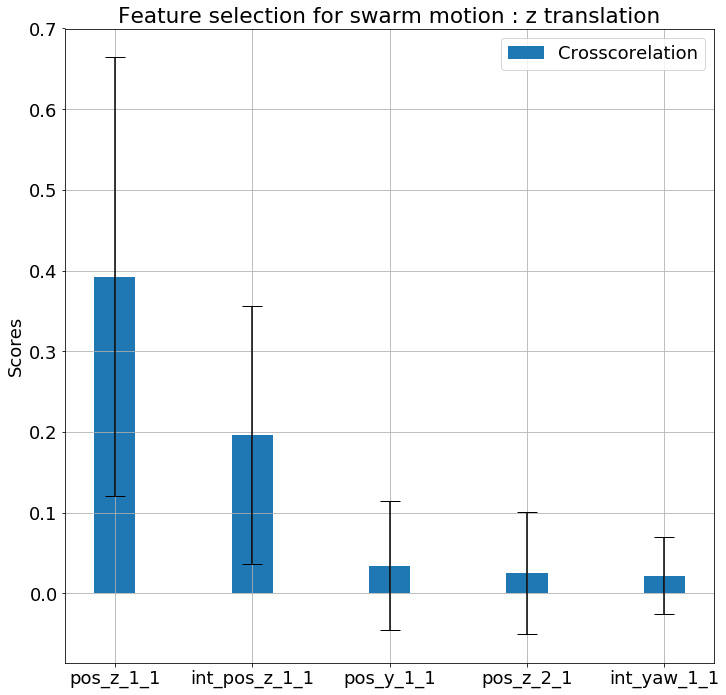

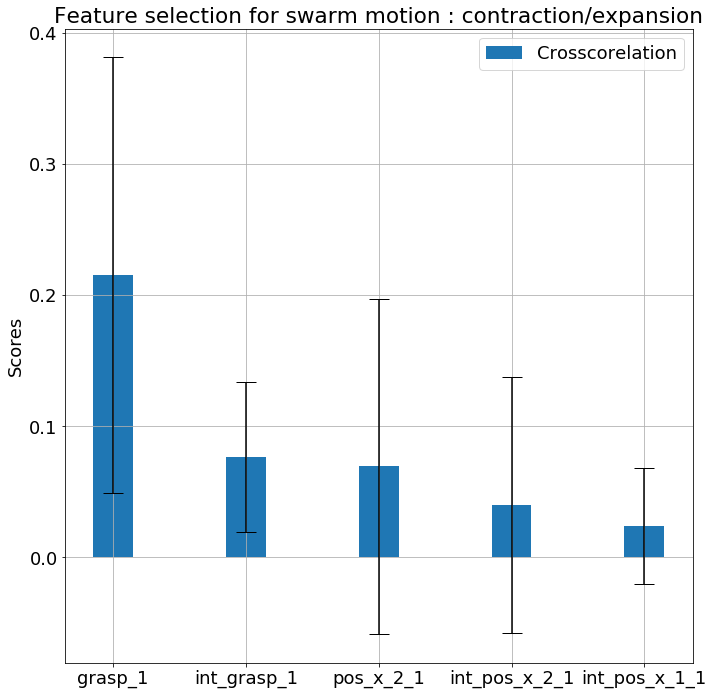

In [14]:
# This is the plot of the figures we had before, not usefull anymore

plt.rcParams.update({'font.size': 18})
outputs_labels = ['x translation', 'y translation', 'z translation', 'contraction/expansion']
print(list(coeff[0].keys())[:-1])
for i,out in enumerate(list(coeff[0].keys())[:-1]):
    n_selected = 5
    ind = np.argpartition(list(coeff_mean[out].values()), -n_selected)[-n_selected:]
    #ind = ind[np.argsort([list(coeff_mean[out].values())[i] for i in ind])] # To sort the array in ascending order
    ind = ind[np.argsort(-np.array([list(coeff_mean[out].values())[i] for i in ind]))] # To sort the array in descending order
    name_ind = np.array(list(coeff_mean[out].keys()))[ind]
    # labels = ['G1', 'G2', 'G3', 'G4', 'G5']
    labels = name_ind
    coeff_means = [coeff_mean[out][n] for n in name_ind]
    coeffStd = [coeff_std[out][n] for n in name_ind]
    #coeffStd = [0 for n in name_ind]

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(2.1*n_selected,10))
    rects1 = ax.bar(x, coeff_means, width, yerr=coeffStd, label='Crosscorelation', capsize=10)
    #rects2 = ax.bar(x + width/2, snr_means, width, yerr=snrStd, label='SNR')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Feature selection for swarm motion : '+outputs_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    #autolabel(rects1)
    #autolabel(rects2)

    fig.tight_layout()
    plt.grid()
    plt.show()